In [1]:
from google.colab import files
uploaded = files.upload()

Saving exponetial.csv to exponetial.csv


In [2]:
import os
os.listdir("/content")

['.config', 'exponetial.csv', 'sample_data']

In [3]:
import pandas as pd

df = pd.read_csv(
    "/content/exponetial.csv",
    comment="#",
    low_memory=False
)

df.head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_dr2_id,gaia_dr3_id,default_flag,...,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,2014-07-23,2011-08,2014-07-23,2.0,1.0,2.0,0.0,0.0,0.0,0.0
1,2,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,1,...,2023-09-19,2023-08,2023-09-19,2.0,1.0,2.0,0.0,0.0,0.0,0.0
2,3,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,2014-05-14,2008-01,2014-05-14,2.0,1.0,2.0,0.0,0.0,0.0,0.0
3,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,1,...,2018-09-04,2017-03,2018-09-06,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,5,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,0,...,2018-04-25,2009-10,2014-05-14,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [4]:
pip install pandas numpy matplotlib seaborn

Original rows: 39251
       planet_radius   planet_mass  orbital_period  semi_major_axis  \
count   27051.000000   7102.000000    3.590700e+04     21959.000000   
mean        5.454365    743.204390    1.218253e+04         4.729047   
std        71.851283   1561.332047    2.122700e+06       180.973883   
min         0.270000      0.015000    9.070629e-02         0.004400   
25%         1.550000     13.500000    4.393157e+00         0.054500   
50%         2.300000    192.604980    1.033929e+01         0.100800   
75%         3.269500    688.143804    2.665656e+01         0.219025   
max      4282.980000  25426.400000    4.020000e+08     19000.000000   

       equilibrium_temp  planet_density     star_temp  star_luminosity  \
count      17219.000000     2728.000000  35722.000000      9658.000000   
mean         880.199727        6.139194   5461.295934        -0.149711   
std          428.622223       65.172013    994.260171         0.718734   
min           34.000000        0.000740    

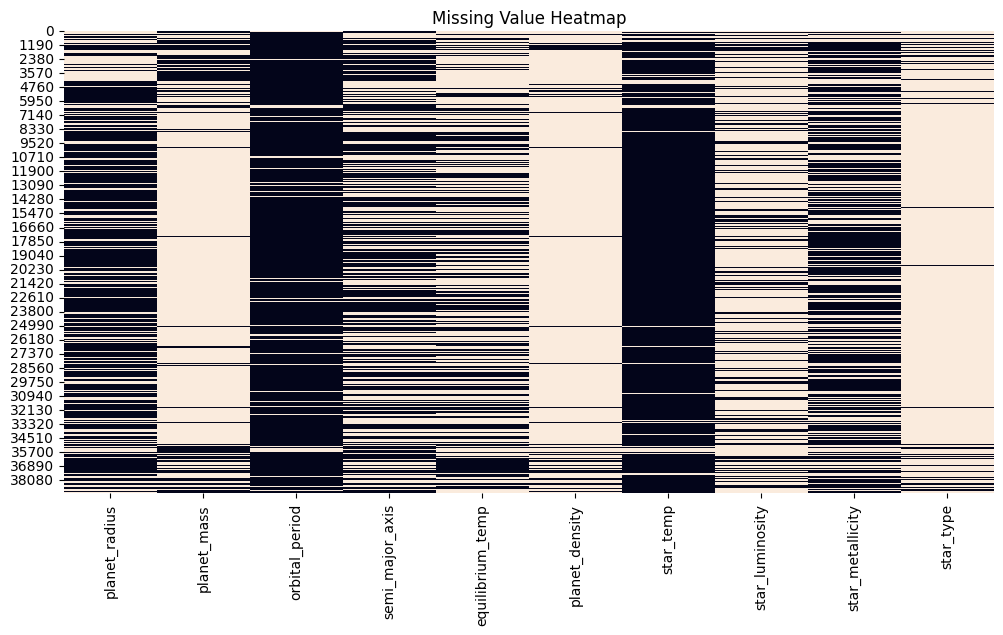

After physical checks: 39251
After soft outlier handling: 39251
Processing complete
Final rows: 33306
Final columns: 24
Saved as: preprocessed.csv


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

df = pd.read_csv("exponetial.csv", comment="#", low_memory=False)
print("Original rows:", df.shape[0])

df = df[[
    "pl_rade",        # Planet radius (Earth radii)
    "pl_bmasse",      # Planet mass (Earth mass)
    "pl_orbper",      # Orbital period (days)
    "pl_orbsmax",     # Semi-major axis (AU)
    "pl_eqt",         # Equilibrium temperature (K)
    "pl_dens",        # Planet density
    "st_teff",        # Star temperature (K)
    "st_lum",         # Star luminosity
    "st_met",         # Star metallicity
    "st_spectype"     # Star type
]]

df.columns = [
    "planet_radius",
    "planet_mass",
    "orbital_period",
    "semi_major_axis",
    "equilibrium_temp",
    "planet_density",
    "star_temp",
    "star_luminosity",
    "star_metallicity",
    "star_type"
]

print(df.describe())

print(df.isnull().sum())

plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

planet_cols = [
    "planet_radius",
    "planet_mass",
    "orbital_period",
    "semi_major_axis",
    "equilibrium_temp",
    "planet_density"
]

for col in planet_cols:
    df[col] = df[col].fillna(df[col].median())

df["star_temp"] = df["star_temp"].fillna(df["star_temp"].median())
df["star_luminosity"] = df["star_luminosity"].fillna(df["star_luminosity"].median())
df["star_metallicity"] = df["star_metallicity"].fillna(df["star_metallicity"].median())

df["star_type"] = df["star_type"].fillna(df["star_type"].mode()[0])

df = df.dropna(how="all")

df = df[
    (df["planet_radius"] > 0) &
    (df["planet_mass"] > 0) &
    (df["equilibrium_temp"] > 0) &
    (df["semi_major_axis"] > 0)
]

print("After physical checks:", df.shape[0])

def cap_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower, upper)
    return data

for col in ["planet_radius", "planet_mass", "equilibrium_temp"]:
    df = cap_iqr(df, col)

print("After soft outlier handling:", df.shape[0])

df["habitability_score"] = (
    (1 - abs(df["equilibrium_temp"] - 288) / 288).clip(0, 1) * 0.4 +
    (1 - abs(df["planet_radius"] - 1)).clip(0, 1) * 0.3 +
    (1 / (1 + abs(df["semi_major_axis"] - 1))).clip(0, 1) * 0.3
)

df["stellar_compatibility"] = (
    (1 - abs(df["star_temp"] - 5778) / 5778).clip(0, 1) * 0.6 +
    (1 - abs(df["star_luminosity"] - 1)).clip(0, 1) * 0.4
)

df["orbital_stability"] = (
    1 / (1 + abs(df["orbital_period"] - 365))
).clip(0, 1)


df["star_class"] = df["star_type"].astype(str).str[0]


df = pd.get_dummies(df, columns=["star_class"], drop_first=True)

df = df.astype({col: int for col in df.columns if col.startswith("star_class_")})

df["habitable"] = (df["habitability_score"] >= 0.4).astype(int)

df = df.drop_duplicates()

df.to_csv("preprocessed.csv", index=False)

print("Processing complete")
print("Final rows:", df.shape[0])
print("Final columns:", df.shape[1])
print("Saved as: preprocessed.csv")

In [20]:
from google.colab import files
files.download("/content/preprocessed.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
df = pd.read_csv("/content/preprocessed.csv")
df.head()

,planet_radius,planet_mass,orbital_period,semi_major_axis,equilibrium_temp,planet_density,star_temp,star_luminosity,star_metallicity,star_type,...,star_class_D,star_class_F,star_class_G,star_class_K,star_class_L,star_class_M,star_class_T,star_class_W,star_class_m,habitable
0,2.3,192.60498,10.339292,1.210,797.0,1.31,5612.5,-0.082525,-0.002,G0 V,...,False,False,True,False,False,False,False,False,False,0
1,2.3,192.60498,323.210000,1.178,797.0,1.31,4874.0,1.978230,-0.260,G8 III,...,False,False,True,False,False,False,False,False,False,0
2,2.3,192.60498,326.030000,1.290,797.0,1.31,4742.0,2.243000,-0.350,G8 III,...,False,False,True,False,False,False,False,False,False,0
3,2.3,192.60498,516.219970,1.530,797.0,1.31,4213.0,-0.082525,-0.020,G0 V,...,False,False,True,False,False,False,False,False,False,0
4,2.3,192.60498,516.220000,1.540,797.0,1.31,4340.0,-0.082525,0.040,K4 III,...,False,False,False,True,False,False,False,False,False,0


In [11]:
df.tail()


,planet_radius,planet_mass,orbital_period,semi_major_axis,equilibrium_temp,planet_density,star_temp,star_luminosity,star_metallicity,star_type,...,star_class_D,star_class_F,star_class_G,star_class_K,star_class_L,star_class_M,star_class_T,star_class_W,star_class_m,habitable
33301,2.3,192.60498,1274.60,2.51000,797.0,1.31,5612.5,-0.082525,-0.002,F8 V,...,False,True,False,False,False,False,False,False,False,0
33302,2.3,192.60498,1276.46,2.51329,797.0,1.31,5612.5,-0.082525,-0.002,F8 V,...,False,True,False,False,False,False,False,False,False,0
33303,2.3,192.60498,385.20,1.18000,797.0,1.31,4836.0,1.800030,-0.200,G9 III,...,False,False,True,False,False,False,False,False,False,0
33304,2.3,192.60498,136.75,0.68000,797.0,1.31,4780.0,1.838850,-0.205,G0 V,...,False,False,True,False,False,False,False,False,False,0
33305,2.3,192.60498,136.97,0.62500,797.0,1.31,4841.0,1.767450,-0.110,K0 III,...,False,False,False,True,False,False,False,False,False,0


In [12]:
df

,planet_radius,planet_mass,orbital_period,semi_major_axis,equilibrium_temp,planet_density,star_temp,star_luminosity,star_metallicity,star_type,...,star_class_D,star_class_F,star_class_G,star_class_K,star_class_L,star_class_M,star_class_T,star_class_W,star_class_m,habitable
0,2.3,192.60498,10.339292,1.21000,797.0,1.31,5612.5,-0.082525,-0.002,G0 V,...,False,False,True,False,False,False,False,False,False,0
1,2.3,192.60498,323.210000,1.17800,797.0,1.31,4874.0,1.978230,-0.260,G8 III,...,False,False,True,False,False,False,False,False,False,0
2,2.3,192.60498,326.030000,1.29000,797.0,1.31,4742.0,2.243000,-0.350,G8 III,...,False,False,True,False,False,False,False,False,False,0
3,2.3,192.60498,516.219970,1.53000,797.0,1.31,4213.0,-0.082525,-0.020,G0 V,...,False,False,True,False,False,False,False,False,False,0
4,2.3,192.60498,516.220000,1.54000,797.0,1.31,4340.0,-0.082525,0.040,K4 III,...,False,False,False,True,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33301,2.3,192.60498,1274.600000,2.51000,797.0,1.31,5612.5,-0.082525,-0.002,F8 V,...,False,True,False,False,False,False,False,False,False,0
33302,2.3,192.60498,1276.460000,2.51329,797.0,1.31,5612.5,-0.082525,-0.002,F8 V,...,False,True,False,False,False,False,False,False,False,0
33303,2.3,192.60498,385.200000,1.18000,797.0,1.31,4836.0,1.800030,-0.200,G9 III,...,False,False,True,False,False,False,False,False,False,0
33304,2.3,192.60498,136.750000,0.68000,797.0,1.31,4780.0,1.838850,-0.205,G0 V,...,False,False,True,False,False,False,False,False,False,0


In [13]:
df.shape

(33306, 24)

In [14]:
df.columns

Index(['planet_radius', 'planet_mass', 'orbital_period', 'semi_major_axis',
       'equilibrium_temp', 'planet_density', 'star_temp', 'star_luminosity',
       'star_metallicity', 'star_type', 'habitability_score',
       'stellar_compatibility', 'orbital_stability', 'star_class_B',
       'star_class_D', 'star_class_F', 'star_class_G', 'star_class_K',
       'star_class_L', 'star_class_M', 'star_class_T', 'star_class_W',
       'star_class_m', 'habitable'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33306 entries, 0 to 33305
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   planet_radius          33306 non-null  float64
 1   planet_mass            33306 non-null  float64
 2   orbital_period         33306 non-null  float64
 3   semi_major_axis        33306 non-null  float64
 4   equilibrium_temp       33306 non-null  float64
 5   planet_density         33306 non-null  float64
 6   star_temp              33306 non-null  float64
 7   star_luminosity        33306 non-null  float64
 8   star_metallicity       33306 non-null  float64
 9   star_type              33306 non-null  object 
 10  habitability_score     33306 non-null  float64
 11  stellar_compatibility  33306 non-null  float64
 12  orbital_stability      33306 non-null  float64
 13  star_class_B           33306 non-null  bool   
 14  star_class_D           33306 non-null  bool   
 15  st

In [16]:
df.describe()

,planet_radius,planet_mass,orbital_period,semi_major_axis,equilibrium_temp,planet_density,star_temp,star_luminosity,star_metallicity,habitability_score,stellar_compatibility,orbital_stability,habitable
count,33306.000000,3.330600e+04,3.330600e+04,33306.000000,33306.0,33306.000000,33306.000000,33306.000000,33306.000000,33306.000000,33306.000000,3.330600e+04,33306.000000
mean,2.411831,1.926050e+02,1.295582e+04,3.114829,797.0,1.705635,5457.281079,-0.101927,-0.000206,0.198313,0.560796,3.353293e-03,0.050742
std,0.827615,5.204093e-11,2.203799e+06,146.950380,0.0,18.695676,988.152766,0.387690,0.165547,0.083742,0.087337,1.066420e-02,0.219473
min,0.643155,1.926050e+02,9.070629e-02,0.004400,797.0,0.000740,415.000000,-4.660000,-2.500000,0.000016,0.000000,2.487564e-09,0.000000
25%,2.010000,1.926050e+02,4.617491e+00,0.100800,797.0,1.310000,5139.000000,-0.082525,-0.018000,0.157961,0.529595,2.763561e-03,0.000000
50%,2.300000,1.926050e+02,1.033929e+01,0.100800,797.0,1.310000,5612.500000,-0.082525,-0.002000,0.157961,0.570717,2.811668e-03,0.000000
75%,2.700000,1.926050e+02,2.366836e+01,0.100800,797.0,1.310000,5893.000000,-0.082525,0.044600,0.201059,0.587517,2.892058e-03,0.000000
max,3.941408,1.926050e+02,4.020000e+08,19000.000000,797.0,2331.000000,57000.000000,3.260760,7.790000,0.571211,0.969100,8.051731e-01,1.000000


In [17]:
df["habitability_score"].head()

,habitability_score
0,0.247934
1,0.254669
2,0.232558
3,0.196078
4,0.194805


In [18]:
df["habitable"].value_counts()

,count
habitable,
0,31616
1,1690
